In [1]:
import sys
import os
sys.path.insert(0, "../../python")

from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from numpy.fft import fft, ifft, fftfreq, fftshift
from lens import profile
from propagation import laser
import numpy as np
from scipy.special import jn
from scipy.integrate import simps
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from lens import bessel


path = '/media/robert/Data_Storage/Data/Tests/Beam_Bessel/'

In [2]:
# Create the desired intensity profile
lam = 0.8
ion = {'atom' : ionization.H2,
       'tau' : 35,
       'type' : 'gaussian'}
z0 = 0.75e6
zf = 50e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

Ez = ionization.field_from_intensity(I)
print('Integral of |Ez|^2:', simps(abs(Ez)**2, z))
print('Sum of |Ez|^2:', np.sum(abs(Ez)**2))

Integral of |Ez|^2: 3896574255.67
Sum of |Ez|^2: 3896684.46846


Integral of |e|^2: 1.55864261312
Sum of |e|^2: 0.00155867378739
Number of modes: 25362


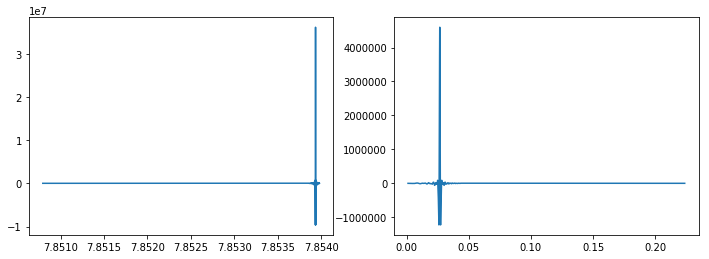

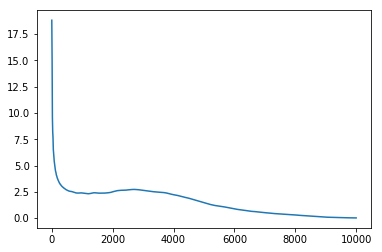

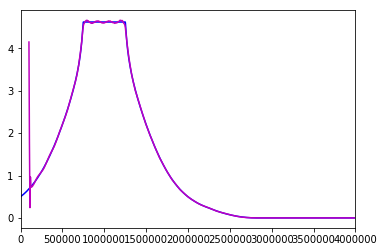

In [3]:
# Find the intensity on a specific grid
Nr = 1000
r = np.linspace(0, 1e4, Nr)
E = np.zeros(Nr, dtype='complex128')
R = 90
k = 2*np.pi/lam
dz = z[1] - z[0]
kr0 = 2.4048 / R
kz0 = np.sqrt(k**2 - kr0**2)
# The next too lines are (kz, e(kz-kzo))\
kz = 2*np.pi * fftshift(fftfreq(N, dz)) + kz0
e = fftshift(fft(Ez)) / N
print('Integral of |e|^2:', simps(abs(e)**2, kz)*zf**2/N**2/2/np.pi)
print('Sum of |e|^2:', np.sum(abs(e)**2)/N)
sel = np.logical_and(abs(e) > 1e-8, kz < k)
kz = kz[sel]
e = e[sel] * zf / np.sqrt(2*np.pi)
print('Number of modes:', len(e))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(kz, e.real)

kr = np.sqrt(k**2 - kz**2)
S = e / kz

plt.subplot(122)
plt.plot(kr, S.real)
plt.show()

E = simps(S[:, None] * jn(0, kr[:, None]*r[None, :]) * kr[:, None], kr, axis=0) / np.sqrt(2*np.pi)
plt.plot(r, abs(E))
plt.show()

zFres = np.linspace(1e5, 6e6, 1000)
eFres = laser.fresnel_axis(E, r, zFres, lam)
IFres = ionization.intensity_from_field(abs(eFres))

plt.plot(z, I, 'b-', zFres, IFres, 'm-')
plt.xlim([0, 4e6])
plt.show()

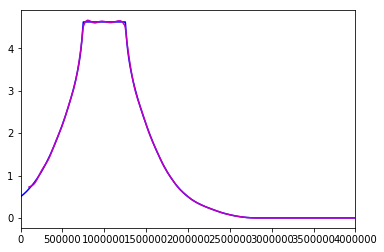

In [4]:
params = {
    'Nr' : 5000,
    'R' : 1e4,
    'w' : 100,
    'lam' : 0.8
}
r, E = bessel.bessel_expansion(params, z, I)
zFres = np.linspace(1e5, 6e6, 1000)
eFres = laser.fresnel_axis(E, r, zFres, lam)
IFres = ionization.intensity_from_field(abs(eFres))

plt.plot(z, I, 'b-', zFres, IFres, 'm-')
plt.xlim([0, 4e6])
plt.show()

Etot out: 0.658216117734 Etot in: 2.86019479644
Etot out: 0.658216117734 Etot in: 0.658216117734


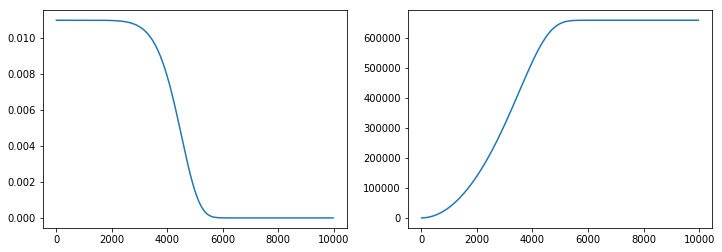

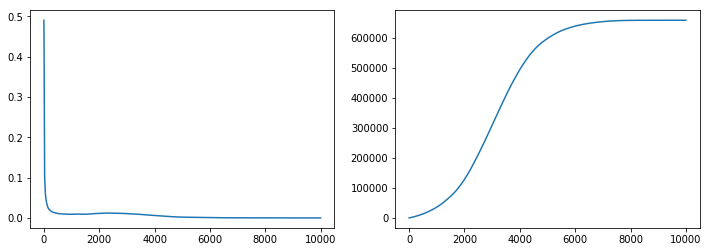

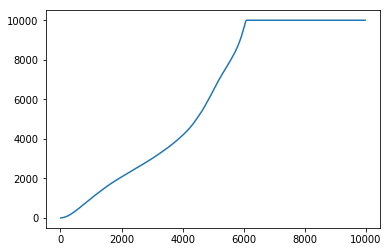

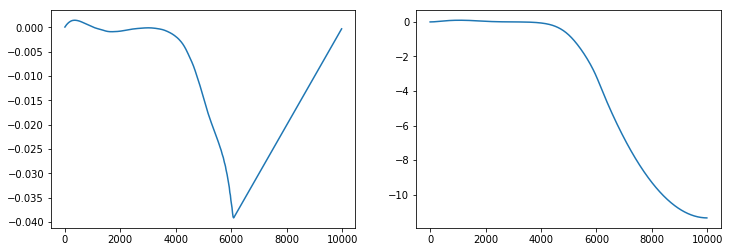

In [5]:
# Lens design for intensity shaping
beamParams = {
    'Nx' : 2**10,
    'Ny' : 2**10,
    'X' : 2e4,
    'Y' : 2e4,
    'lam' : 0.8,
    'path' : path,
    'name' : 'SuperGaussian',
    'threads' : 4,
    'cyl' : True,
    'E0' : 6,
    'waist' : 5e3,
    'order' : 8
}

L = 10e4
beam = laserbeam.SuperGaussianLaser(beamParams)
N = int(beam.Nx/2)

Iout = beam.intensity_from_field(E)
rout = r
Iin = beam.intensity_from_field(beam.e[N:, int(beam.Ny/2)])
rin = beam.x[N:]
Etotout = beam.total_cyl_power(rout, Iout)
Etotin = beam.total_cyl_power(rin, Iin)
print('Etot out:', Etotout, 'Etot in:', Etotin)
# Rescale the input beam to match the output
frac = np.sqrt(Etotout/Etotin)
beam.E0 *= frac
beam.initialize_field()
Iin = beam.intensity_from_field(beam.e[N:, int(beam.Ny/2)])
Etotin = beam.total_cyl_power(rin, Iin)
print('Etot out:', Etotout, 'Etot in:', Etotin)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(rin, Iin)

Ein = np.cumsum(np.pi*(Iin[:-1] + Iin[1:])*(rin[1:]**2 - rin[:-1]**2)/2)
plt.subplot(122)
plt.plot((rin[1:] + rin[:-1])/2, Ein)
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(rout, Iout)

Eout = np.cumsum(np.pi*(Iout[:-1] + Iout[1:])*(rout[1:]**2 - rout[:-1]**2)/2)
plt.subplot(122)
plt.plot((rout[1:] + rout[:-1])/2, Eout)
plt.show()

# Map anything outside the interpolation range to 0 or the max radius
rout = interp1d(Eout, (rout[1:] + rout[:-1])/2, bounds_error=False, fill_value=(0, rout[-1]))
rout = rout(Ein)
plt.plot((rin[1:] + rin[:-1])/2, rout)
plt.show()
dphidr = -(rout - (rin[1:] + rin[:-1])/2)/np.sqrt(L**2 + (rout - (rin[1:] + rin[:-1])/2)**2)
phi = np.zeros(N, dtype='double')
dr = r[1]-r[0]
# If we force rin to be evenly spaced then
phi[1:] = np.cumsum(dphidr*dr)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot((rin[1:] + rin[:-1])/2, dphidr)
plt.subplot(122)
plt.plot(rin, phi)
plt.show()
phi = beam.reconstruct_from_cyl(rin, phi, beam.x, beam.y)
beam.set_field(beam.e * np.exp(1j*k*phi))
beam.propagate(L, 1)

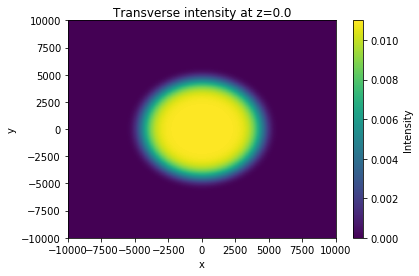

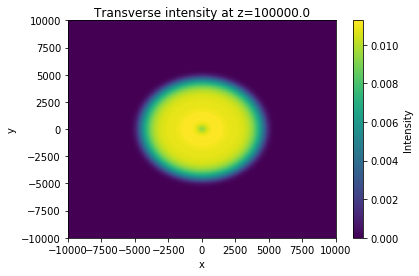

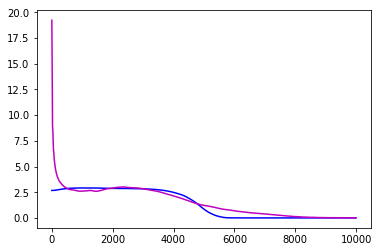

In [6]:
beam.plot_intensity_at(0)
beam.plot_current_intensity()
plt.plot(beam.x[N:], abs(beam.e[N:, int(beam.Ny/2)]), 'b', r, abs(E), 'm')
plt.show()